<a href="https://colab.research.google.com/github/sashapff/recommender_systems/blob/main/recsys_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download data

In [100]:
!pip install kaggle

In [101]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"sashapff","key":"262d5a2d6c417f7875aefdf6948939d5"}'}

In [102]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [103]:
!kaggle competitions download -c kkbox-music-recommendation-challenge

song_extra_info.csv.7z: Skipping, found more recently modified local copy (use --force to force download)
train.csv.7z: Skipping, found more recently modified local copy (use --force to force download)
test.csv.7z: Skipping, found more recently modified local copy (use --force to force download)
members.csv.7z: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.7z: Skipping, found more recently modified local copy (use --force to force download)
songs.csv.7z: Skipping, found more recently modified local copy (use --force to force download)


In [104]:
!7z e train.csv.7z
!7z e songs.csv.7z
!7z e song_extra_info.csv.7z
!7z e members.csv.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 106420688 bytes (102 MiB)

Extracting archive: train.csv.7z
--
Path = train.csv.7z
Type = 7z
Physical Size = 106420688
Headers Size = 122
Method = LZMA2:24
Solid = -
Blocks = 1

  0%    
Would you like to replace the existing file:
  Path:     ./train.csv
  Size:     971675848 bytes (927 MiB)
  Modified: 2017-09-22 00:08:34
with the file from archive:
  Path:     train.csv
  Size:     971675848 bytes (927 MiB)
  Modified: 2017-09-22 00:08:34
? (Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? N

  0% . train.csv                  3% . train.csv                  6% . train.csv                  9% . 

## Preprocess data

In [105]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Download and preprocess train dataset

In [106]:
train_types = {'msno': 'category',
               'song_id': 'category',
               'source_system_tab': 'category',
               'source_screen_name': 'category',
               'source_type': 'category',
               'target': np.uint8}

In [107]:
train = pd.read_csv('/content/train.csv', dtype=train_types)

In [108]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [109]:
train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 6 columns):
 #   Column              Non-Null Count    Dtype   
---  ------              --------------    -----   
 0   msno                7377418 non-null  category
 1   song_id             7377418 non-null  category
 2   source_system_tab   7352569 non-null  category
 3   source_screen_name  6962614 non-null  category
 4   source_type         7355879 non-null  category
 5   target              7377418 non-null  uint8   
dtypes: category(5), uint8(1)
memory usage: 84.6 MB


Features `source_system_tab`, `source_screen_name` and `source_type` have some NaNs, so drop rows with NaNs.

In [110]:
print('Train length before drop nans', train.shape)
train = train.dropna()
print('Train length after drop nans', train.shape)

Train length before drop nans (7377418, 6)
Train length after drop nans (6959297, 6)


The size of the dataset doesn't change significant.

### Download and preprocess songs dataset

In [111]:
songs_types = {'song_id': 'category',
               'song_length': np.uint64,
               'artist_name': 'category',
               'language': np.float64}

In [112]:
songs = pd.read_csv('/content/songs.csv', dtype=songs_types)

In [113]:
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [114]:
songs.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2296320 entries, 0 to 2296319
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype   
---  ------       --------------    -----   
 0   song_id      2296320 non-null  category
 1   song_length  2296320 non-null  uint64  
 2   genre_ids    2202204 non-null  object  
 3   artist_name  2296320 non-null  category
 4   composer     1224966 non-null  object  
 5   lyricist     351052 non-null   object  
 6   language     2296319 non-null  float64 
dtypes: category(2), float64(1), object(3), uint64(1)
memory usage: 214.3+ MB


Features `composer` and `lyricist` have a lot Nans, so we can drop these columns at all. Features `genre_ids` and `language` has some NaNs, but we won't drop rows with NaNs and fill NaNs with the default value.

In [115]:
songs['lyricist'] = songs['lyricist'].fillna('Other')
songs['composer'] = songs['composer'].fillna('Other')

Look at unique values and the histogram of `language` feature.

In [116]:
songs['language'].unique()

array([ 3., 31., 52., 17., 10., -1., 24., 59., 45., 38., nan])

(array([ 745762.,   15482.,       0.,   92518.,   41744.,   39201.,
           2385.,   14435., 1336694.,    8098.]),
 array([-1.,  5., 11., 17., 23., 29., 35., 41., 47., 53., 59.]),
 <a list of 10 Patch objects>)

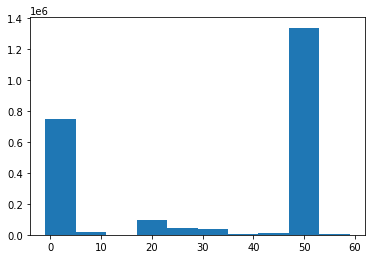

In [117]:
plt.hist(songs['language'])

I think we can change NaN to the most popular `language` (value 53).

In [118]:
songs['language'] = songs['language'].fillna(53)

Then I will change NaN in the `genre_ids` feature to the new genre with is 239239 value.

In [119]:
songs['genre_ids'] = songs['genre_ids'].fillna('239239')

In [ ]:
songs.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2296320 entries, 0 to 2296319
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype   
---  ------       --------------    -----   
 0   song_id      2296320 non-null  category
 1   song_length  2296320 non-null  uint64  
 2   genre_ids    2296320 non-null  object  
 3   artist_name  2296320 non-null  category
 4   composer     2296320 non-null  object  
 5   lyricist     2296320 non-null  object  
 6   language     2296320 non-null  float64 
dtypes: category(2), float64(1), object(3), uint64(1)
memory usage: 214.3+ MB


### Download and preprocess members dataset

In [ ]:
members_types = {'msno': 'category',
                 'city': np.uint64,
                 'bd': np.uint64,
                 'registered_via': np.uint64}

In [ ]:
members = pd.read_csv('/content/members.csv', dtype=members_types, parse_dates=['registration_init_time', 'expiration_date'])

In [ ]:
members.head()

In [ ]:
members.info(verbose=True, null_counts=True)

Features `gender` have a lot Nans, so drop fill NaNs with new category `other`.

In [ ]:
members['gender'] = members['gender'].fillna('other')

In [ ]:
members.info(verbose=True, null_counts=True)

Now all tables are filled.

### Download and preprocess songs extra info dataset

In [ ]:
songs_extra = pd.read_csv('/content/song_extra_info.csv')

In [ ]:
songs_extra.head()

In [ ]:
songs_extra.info(verbose=True, null_counts=True)

In [ ]:
# Fill NaNs
songs_extra['name'] = songs_extra['name'].fillna('!!!!!!!!!!!!!!!!!!')
songs_extra['isrc'] = songs_extra['isrc'].fillna('OTHER')

In [ ]:
songs_extra.info(verbose=True, null_counts=True)

### Check target distribution

In [ ]:
plt.hist(train['target'])

The targets are balanced.

## Feature engineering

In [ ]:
!pip install category_encoders

In [ ]:
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import minmax_scale

In [39]:
data = train.copy()

In [40]:
data = data.merge(songs, on='song_id')
data = data.merge(members, on='msno')

In [41]:
def encode(dataset, feature):
    encoder = TargetEncoder()
    encoder.fit(dataset[feature], dataset.target)
    dataset[feature] = encoder.transform(dataset[feature].astype('category'))

Add some new features.

In [42]:
data['first_genre'] = [int(str(i).split('|')[0]) for i in data['genre_ids']]
encode(data, 'first_genre')

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [43]:
data['second_genre'] = [int(str(i).split('|')[1]) if len(str(i).split('|')) > 1 else 239239 for i in data['genre_ids']]
encode(data, 'second_genre')

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [44]:
data['third_genre'] = [int(str(i).split('|')[2]) if len(str(i).split('|')) > 2 else 239239 for i in data['genre_ids']]
encode(data, 'third_genre')

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [45]:
# One hot encode for other features
feature_onehot = pd.get_dummies(data.gender)
for name in feature_onehot.columns:
    data['gender_' + name] = feature_onehot[name]
encode(data, 'gender')

# feature_onehot = pd.get_dummies(data.registered_via)
# for name in feature_onehot.columns:
#     data['registered_via_' + str(name)] = feature_onehot[name]
encode(data, 'registered_via')

feature_onehot = pd.get_dummies(data.city)
for name in feature_onehot.columns:
    data['city_' + str(name)] = feature_onehot[name]
encode(data, 'city')

# feature_onehot = pd.get_dummies(data.source_type)
# for name in feature_onehot.columns:
#     data['source_type_' + name] = feature_onehot[name]
encode(data, 'source_type')

# feature_onehot = pd.get_dummies(data.source_system_tab)
# for name in feature_onehot.columns:
#     data['source_system_tab_' + name] = feature_onehot[name]
encode(data, 'source_system_tab')

feature_onehot = pd.get_dummies(data.language)
for name in feature_onehot.columns:
      data['language_' + str(name)] = feature_onehot[name]
encode(data, 'language')

# feature_onehot = pd.get_dummies(data.source_screen_name)
# for name in feature_onehot.columns:
#       data['source_screen_name_' + str(name)] = feature_onehot[name]
encode(data, 'source_screen_name')

# Split registration_init_time to 3 features
data['registration_year'] = data.registration_init_time.dt.year
data['registration_month'] = data.registration_init_time.dt.month
data['registration_day'] = data.registration_init_time.dt.day
data['registration_init_time_sec'] = data.registration_init_time.dt.year * 365 + data.registration_init_time.dt.month * 30 + data.registration_init_time.dt.day
# encode(data, 'registration_init_time')


# Split expiration_date to 3 features
data['expiration_year'] = data.expiration_date.dt.year
data['expiration_month'] = data.expiration_date.dt.month
data['expiration_day'] = data.expiration_date.dt.day
data['expiration_date_sec'] = data.expiration_date.dt.year * 365 + data.expiration_date.dt.month * 30 + data.expiration_date.dt.day
# encode(data, 'expiration_date')

# Add a new feature
data['time_on_service'] = data['expiration_date_sec'] - data['registration_init_time_sec']

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [46]:
encode(data, 'artist_name')
encode(data, 'msno')
encode(data, 'song_id')
encode(data, 'genre_ids')
encode(data, 'lyricist')
encode(data, 'composer')

data = data.drop(columns=['bd'])

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: Future

In [47]:
# data.head()

In [48]:
# for feature in data.columns:
#     print(feature, data[feature].unique())

## GBDT

In [49]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

In [50]:
data.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,city,gender,registered_via,registration_init_time,expiration_date,first_genre,second_genre,third_genre,gender_female,gender_male,gender_other,city_1,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10,city_11,city_12,city_13,city_14,city_15,city_16,city_17,city_18,city_19,city_20,city_21,city_22,language_-1.0,language_3.0,language_10.0,language_17.0,language_24.0,language_31.0,language_45.0,language_52.0,language_59.0,registration_year,registration_month,registration_day,registration_init_time_sec,expiration_year,expiration_month,expiration_day,expiration_date_sec,time_on_service
0,0.500200,0.500200,0.610112,0.627051,0.636732,1,269061,0.512583,0.791667,0.459964,0.469683,3.0,1,0.495191,7,2016-08-26,2017-09-30,465,239239,239239,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2016,8,26,736106,2017,9,30,736505,399
1,0.500200,0.134524,0.610112,0.627051,0.636732,0,256940,0.512583,0.375000,0.444463,0.449275,3.0,13,0.511056,9,2010-05-14,2017-10-21,465,239239,239239,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2010,5,14,733814,2017,10,21,736526,2712
2,0.261866,0.134524,0.610112,0.627051,0.636732,0,256940,0.512583,0.375000,0.444463,0.449275,3.0,13,0.496975,3,2013-03-24,2017-09-21,465,239239,239239,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2013,3,24,734859,2017,9,21,736496,1637
3,0.261866,0.500009,0.415804,0.627051,0.636732,1,203406,0.512583,0.550000,0.500009,0.469683,52.0,13,0.496975,3,2013-03-24,2017-09-21,465,239239,239239,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2013,3,24,734859,2017,9,21,736496,1637
4,0.261866,0.500200,0.610112,0.627051,0.636732,0,258484,0.512583,0.444444,0.738153,0.500009,3.0,13,0.496975,3,2013-03-24,2017-09-21,465,239239,239239,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2013,3,24,734859,2017,9,21,736496,1637


In [51]:
X = data.drop(columns=['target', 'expiration_date', 'registration_init_time'])
y = data['target']

skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

# model = XGBClassifier(tree_method='gpu_hist', gpu_id=0)
# parameters = {'model__max_depth':[3, 5, 10], 
#               'model__sampling_method':['uniform', 'gradient_based'], 
#               'model__n_estimators':[25, 50],
#               'model__splitter':['best', 'random'],
#               'model__criterion':['gini', 'entropy'],
#               'model__min_samples_leaf':[1, 5, 10]}
# clf = GridSearchCV(model, parameters, scoring='roc_auc', cv=skf, n_jobs=-1)
# _ = clf.fit(X, y)

# print('XGBClassifier', clf.best_params_)

# best_model = XGBClassifier(max_depth=clf.best_params_['model__max_depth'],
#                            sampling_method=clf.best_params_['model__sampling_method'],
#                            tree_method='gpu_hist', gpu_id=0, 
#                            n_estimators=clf.best_params_['model__n_estimators'],
#                            splitter=clf.best_params_['model__splitter'],
#                            criterion=clf.best_params_['model__criterion'],
#                            min_samples_leaf=clf.best_params_['model__min_samples_leaf'])
best_model = XGBClassifier(tree_method='gpu_hist', gpu_id=0, n_jobs=-1,
                           n_estimators=30, max_depth=3)
_ = best_model.fit(X, y)
score = cross_validate(best_model, X, y, cv=skf, n_jobs=-1, verbose=1)['test_score']

print(f'ROC AUC for the best model: {np.mean(score)}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


ROC AUC for the best model: 0.7807999999999999


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished


### Feature imporatances

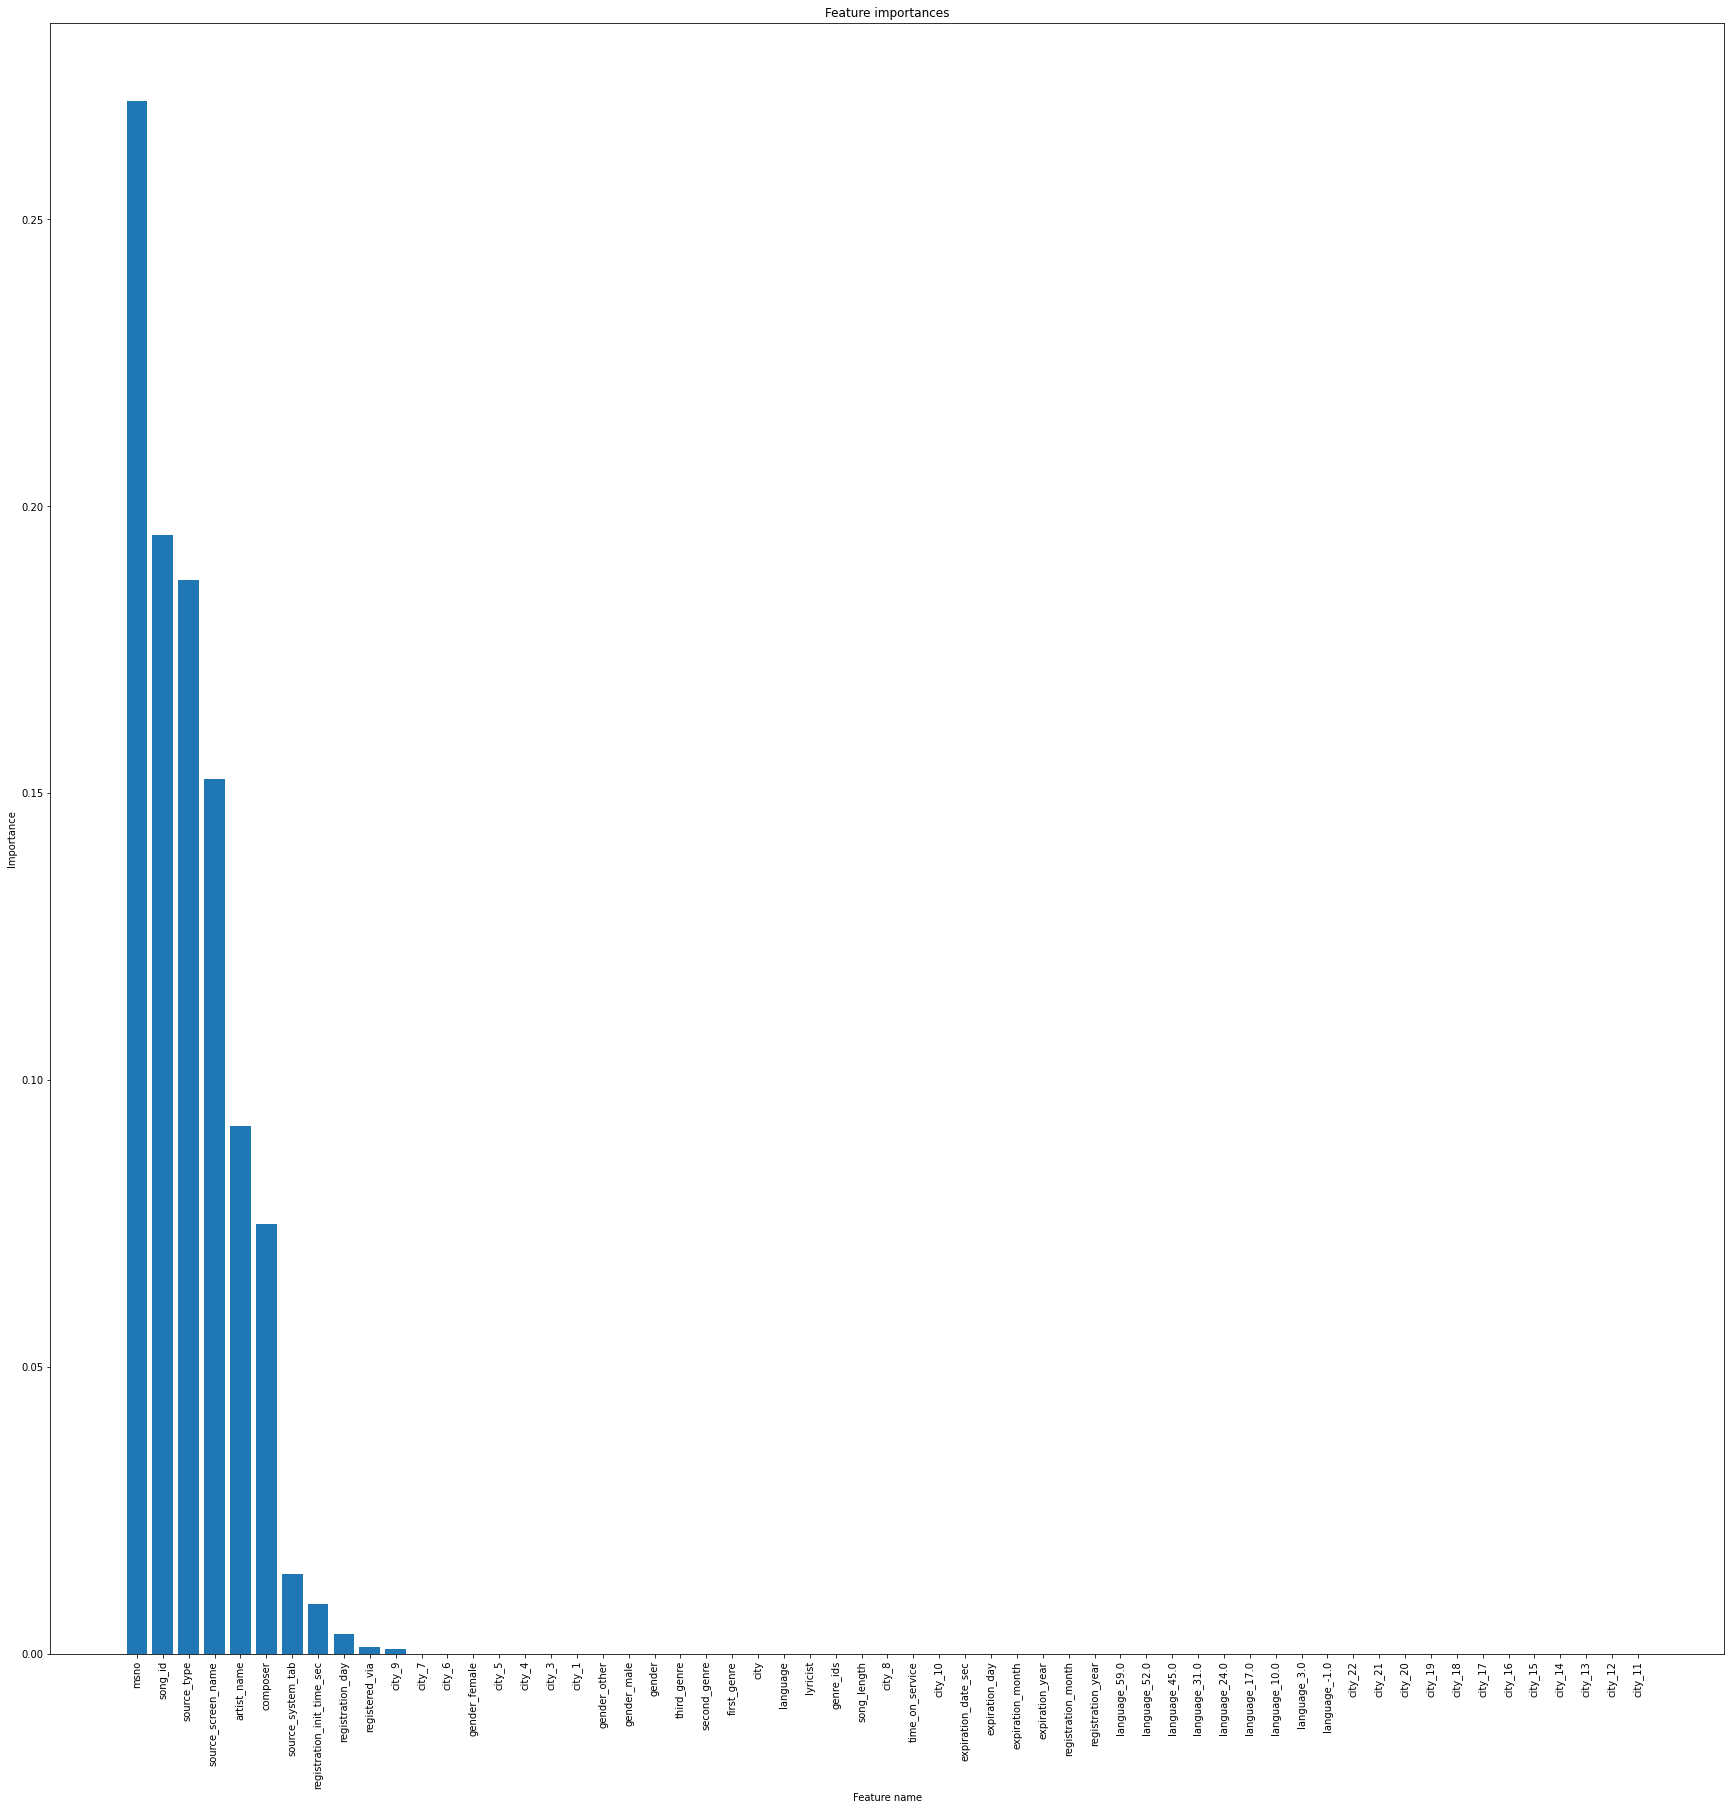

In [52]:
importances = best_model.feature_importances_

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(30, 30))

plt.title('Feature importances')
plt.ylabel('Importance')
plt.xlabel('Feature name')

plt.bar(range(len(X.columns)), importances[indices])
plt.xticks(range(len(X.columns)),X.columns[indices],rotation=90)
plt.show()

In [68]:
# Drop not important features
X = data[['msno', 'song_id', 'source_type', 'source_screen_name', 'artist_name', 
          'composer', 'source_system_tab', 'registration_init_time_sec', 'registration_day',
          'registered_via', 'city_9']]
y = data['target']

best_model = XGBClassifier(tree_method='gpu_hist', gpu_id=0, n_jobs=-1,
                           n_estimators=100, max_depth=3, random_state=1)
_ = best_model.fit(X, y)
score = cross_validate(best_model, X, y, cv=skf, n_jobs=-1, verbose=1)['test_score']

print(f'ROC AUC for the best model: {np.mean(score)}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


ROC AUC for the best model: 0.7841


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


## Build embeddings

In [135]:
from tqdm import tqdm
from gensim.models import Word2Vec
import multiprocessing

In [136]:
emb_data = train.merge(songs.merge(songs_extra, on=['song_id', 'song_id']), on='song_id').sample(100000)

In [137]:
targeted = emb_data.loc[emb_data.target == 1, ['msno']]
targeted['song'] = emb_data.apply(lambda x: str(x['artist_name']) + ' | '  
                                  + str(x['name']) + ' | ' 
                                  + str(x['composer']) + ' | ' + 
                                  str(x['lyricist']), axis=1)

In [139]:
targeted.head()

,msno,song
524782,oF4/dEI3s3hXR+xju7VnDStzgYFCCbueQaw2MFeuGpc=,Carly Rae Jepsen | I Really Like You | Carly R...
1481758,Bw+PhddPd6uyy6LYG6UrV2uM7LtwijHYJZdOD2BzcgE=,周杰倫 (Jay Chou) | 髮如雪 | 周杰倫 | 方文山
298680,AvAe2Lp/Ncm+oGOkJpI3EwJz7wyPrfCOwbpsJCF8YJA=,Calvin Harris | This Is What You Came For | Ca...
66178,WI6ii34ufr52oLNj6LI5U2v15B+UNztuhmyMChbTIOE=,五月天 (Mayday) | 好好 (想把你寫成一首歌) (Song About You) ...
2309052,iV5B5c2Mnm9J3/MYJhjcvdCGMb54O+ZmYwxzLlkh4HY=,One Direction | Perfect | Harry Styles|Julian ...


In [138]:
targeted_numpy = targeted.to_numpy()
dictionary = [[str(x[1]) for x in targeted_numpy[targeted_numpy[:, 0] == user]] for user in targeted.msno.unique()]

In [176]:
dictionary[200:250]

[['張宇 (Phil Chang) | 月亮惹的禍 | 張宇 | 十一郎',
  '周華健 (Emil Chau) | 風雨無阻 | Other | Other'],
 ['孫子涵 (Niko Sun) | 晃著晃著就老了 (Grow Old) | 孫子涵 | 孫子涵'],
 ['田馥甄 (Hebe) | PLAY 我呸 | 倪子岡 | 李格弟',
  '五月天 (Mayday) | 知足 | Other | Other',
  '李聖傑 (Sam Lee) | 光 | Other | Other',
  '周杰倫 (Jay Chou) | 告白氣球 | 周杰倫 | 方文山'],
 ['Celine Dion | A New Day Has Come | Other | Other',
  '施文彬 (Michael Shih) | 再會啦心愛的無緣的人 | Other | Other'],
 ['林俊傑 (JJ Lin) | 星球 | 林俊傑 | 張思爾',
  'G.E.M.鄧紫棋 | 盲點 (Blindspot) | G.E.M. 鄧紫棋 | G.E.M. 鄧紫棋'],
 ['五月天 (Mayday) | 兄弟 (Brotherhood) | 阿信 | 阿信'],
 ['劉若英 (Rene Liu) | 幸福不是情歌【三立偶像劇[兩個爸爸]片尾曲】 | 木蘭號AKA陳韋伶 | 木蘭號AKA陳韋伶/黃婷',
  'MP魔幻力量 (Magic Power) | 戰神 | MP魔幻力量 廷廷 | MP魔幻力量 廷廷',
  'Various Artists | 新不了情 | 鮑比達 | 黃鬱',
  '畢書盡 (Bii) | 我們在愛中漫步 | 陳彥允 | 陳彥允'],
 ['崔健 | 一無所有 | Other | Other',
  'Daniel Ho | Pineapple Mango 早餐之歌-鳳梨芒果 | Other | Other',
  'aMEI (張惠妹) | The Power Of Love | Gunther Mende Candy De Rouge Jennifer | Gunther Mende Candy De Rouge Jennifer',
  '芝麻+龍眼 | 秋蟬 | 李子恆 | 李子恆',
  '古箏佛讚 | 大雄寶殿 | 

In [170]:
model = Word2Vec(workers=multiprocessing.cpu_count())
model.build_vocab(dictionary)
model.train(dictionary, total_examples=model.corpus_count, epochs=100, report_delay=1)

(2800223, 5067600)

In [171]:
def get_similar(name):
    for item in model.wv.most_similar(name)[:5]:
        print(f'score {item[1]} for {item[0]}')

In [158]:
get_similar('OneRepublic | Counting Stars | Ryan Tedder | Other')

score 0.6837910413742065 for Hardwell | Area51 | Robbert van de Corput| Dallas Koehlke | Robbert van de Corput| Dallas Koehlke 
score 0.6765733957290649 for Armin van Buuren | Off The Hook | B. De Goeij| R. van de Corput| A. van Buuren | Other 
score 0.6645190715789795 for Nicki Minaj | The Boys | Jean Baptiste| Jonas Jeberg| Onika Maraj| Anjulie Persaud | Other 
score 0.6600489616394043 for twenty one pilots | The Judge | Other | Other 
score 0.6540428400039673 for Calvin Harris | Bounce (Radio Edit) | Calvin Harris | Calvin Harris 


In [177]:
get_similar('Sia | Chandelier | Sia Furler|Jesse Shatkin | Sia Furler|Jesse Shatkin')

score 0.5410754680633545 for 林俊傑 (JJ Lin) | 我還想她 | 林俊傑 | 邢增華
score 0.5080439448356628 for 周杰倫 (Jay Chou) | 美人魚 | 周杰倫 | 羅宇軒/黃婕熙
score 0.497592568397522 for 八三夭 (The Last Day of Summer 831) | 熊麻吉 | 八三夭 阿璞 | 八三夭 阿璞
score 0.4923212230205536 for Maroon 5 | Won't Go Home Without You | Adam Levine | Other
score 0.4676564931869507 for 張震嶽 | 愛的初體驗 | 張震嶽 | 張震嶽


In [147]:
get_similar('Taylor Swift | Fifteen | Taylor Swift | Other')

score 0.9245916604995728 for Red Hot Chili Peppers | Can't Stop | Anthony Kiedis| Chad Smith| Flea| John Frusciante | Other 
score 0.8892691135406494 for 旺福 (Wonfu) | 有星星的晚上 | 姚小民 | 姚小民 
score 0.8615117073059082 for 李其燊 | 哭為你笑為你 | 李其燊 | 李其燊 
score 0.8614200949668884 for 張懸 (Deserts Xuan) | 藍天白雲 (Lan Tian Bai Yun) | Deserts | Deserts 
score 0.8555311560630798 for BY2 | Don't Go Away | Miko+Yumi+馮時澤 |  Miko+Yumi+Mr. Mars+馮時澤 


In [149]:
get_similar('Alan Walker | Alone | Alan Walker| Jesper Borgen| Anders Froen| Gunnar Greve| Jonnali Parmenius | Alan Walker| Jesper Borgen| Anders Froen| Gunnar Greve| Jonnali Parmenius')

score 0.5239980816841125 for Rihanna | Loveeeeeee Song | Nayvadius Wilburn| Denisea "Blue June" Andrews| Robyn Fenty| George S. Jackson| Leshawn S. Rogers| Emmanuel Zaragoza | Other 
score 0.5213751792907715 for Era | Madona | Eric Lévi | Other 
score 0.5146851539611816 for Passenger | Beautiful Birds | Michael David Rosenberg | Michael David Rosenberg 
score 0.5073674321174622 for 張瑋 | 黑白 (Hei Bai) | Eric Chou | Rui-Ye 
score 0.5067639350891113 for 陳詩妤 | 心口的微光 | 徐偉銘 | 吳易緯 


### Shap values

In [ ]:
# !pip install shap

In [ ]:
# from shap import TreeExplainer

In [ ]:
# shap_values = TreeExplainer(best_model).shap_values(X)
# shap.summary_plot(shap_values, X, max_display=X.shape[1])